Laden der notwendigen Bibliotheken

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage, NonUniformImage
import numpy as np
import math
import cv2
from PIL import Image
from astropy.io import fits
from pathlib import Path
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import load_model
from prettytable import PrettyTable



In [2]:
# Lädt ein Bild
def load_image(path,image_size=32, scale=255):
    img =cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    tmp = img.reshape([image_size, image_size,1])


    return np.array(tmp)/scale

In [3]:
def compute_dispersion_ml(model, labels_decoded, path, image_size=32, shape=(3284,4944), figure_size=(12,8)):
    correct_matches = 0
    result_table = PrettyTable()
    result_table.field_names = ["Datei ", "Position", "Wavelength"]

    raw_positions = []
    raw_wavelengths = []
    for filename in sorted(os.listdir(path)):

        if(filename.startswith('.') == False):

            current_wavelength = filename[0:4]
            print (current_wavelength)
            image_path = os.path.join(path,filename)
                
            test_image = load_image(image_path)
            predictions = model.predict(test_image.reshape((1,image_size,image_size,1)))
                
            index_max_predictions = np.argmax(predictions)
            print('index_max_predictions:',index_max_predictions, current_wavelength, labels_decoded[index_max_predictions])
            decode_wavelength = labels_decoded[index_max_predictions]

            result_table.add_row([image_path, current_wavelength, decode_wavelength])
            raw_positions.append(float(current_wavelength))
            raw_wavelengths.append(float(decode_wavelength))


    print(result_table)

    l = len(raw_positions)

    positions = []
    wavelengths = []

    for l in range(0,l):
        try:
            if raw_wavelengths[l] > raw_wavelengths[l-1] and raw_wavelengths[l] < raw_wavelengths[l+1]:
                positions.append(raw_positions[l])
                wavelengths.append((raw_wavelengths[l]))
        except IndexError:
            pass

    x = range(0,shape[1])
    
    plt.rcParams['figure.figsize'] = figure_size
    fig, axes = plt.subplots()
    plt.xlim = [0,4944]
    plt.ylim = [4000,7500]
    plt.plot(positions, wavelengths,'+', color='k')
    z_ml = np.polyfit(positions, wavelengths,1)
    p_ml = np.poly1d(z_ml)
    waves_ml = p_ml(x)
    plt.plot(x, waves_ml, color='cyan')        
    plt.ylabel('Wavelength (A)')
    plt.xlabel('Pixel')
    plt.show()
    return z_ml

In [4]:
import tomllib
with open("compute_dispersion_ml.toml", "rb") as config_f:
    config = tomllib.load(config_f)

In [5]:

print(config)

{'DEFAULT': {'WINDOW': 512, 'IMAGE_SIZE': 32, 'TEST_DATA_PATH': '../test/images', 'INTENSITY_SCALE': 1024, 'FIGURE_SIZE': [12, 8], 'VMIN': 250, 'VMAX': 300, 'TRACE_ROW': 1500, 'FIND_PEAKS': {'MIN_INTENSITY': 0.05, 'DISTANCE': 15}}, 'SPECTRUM': {'fits_file': '../data/NEON/Light_NEON_10sec_Bin1_22.1C_gain0_2025-06-04_211202_frame0001.fit'}, 'MODEL': {'TRAIN_DATA_PATH': '../../keras_based_line_identification/data/train', 'MODEL_FILE': '../data/model/model.h5'}}


In [6]:
WINDOW = config['DEFAULT']['WINDOW']
IMAGE_SIZE = config['DEFAULT']['IMAGE_SIZE']
TEST_DATA_PATH = Path(config['DEFAULT']['TEST_DATA_PATH'])
INTENSITY_SCALE = config['DEFAULT']['INTENSITY_SCALE']
FIGURE_SIZE = config['DEFAULT']['FIGURE_SIZE']
VMIN = config['DEFAULT']['VMIN']
VMAX = config['DEFAULT']['VMAX']

In [7]:
TEST_DATA_PATH.mkdir(parents=True, exist_ok=True)

Definition des Kalibrierspektrums

In [8]:
fits_file = config['SPECTRUM']['fits_file']


Laden der FITS-Datei

In [9]:
with fits.open(str(fits_file)) as hdul:
    hdul.info()
    data = hdul[0].data

Filename: ../data/NEON/Light_NEON_10sec_Bin1_22.1C_gain0_2025-06-04_211202_frame0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (4944, 3284)   int16 (rescales to uint16)   


Anzeige der FITS Datei

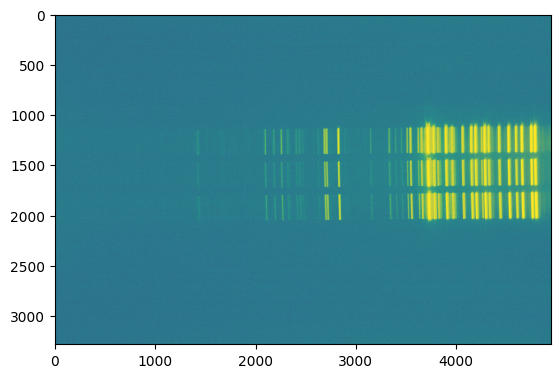

In [10]:
fig, axes = plt.subplots()
plt.imshow(data,vmin=250,vmax=300)
plt.show()

Auswahl eines Schnitts bei y = 1500 entlang der Dispersionsachse

In [11]:
trace = data[config['DEFAULT']['TRACE_ROW'],:]
trace_n = trace/max(trace)

Anzeige des Schnitts

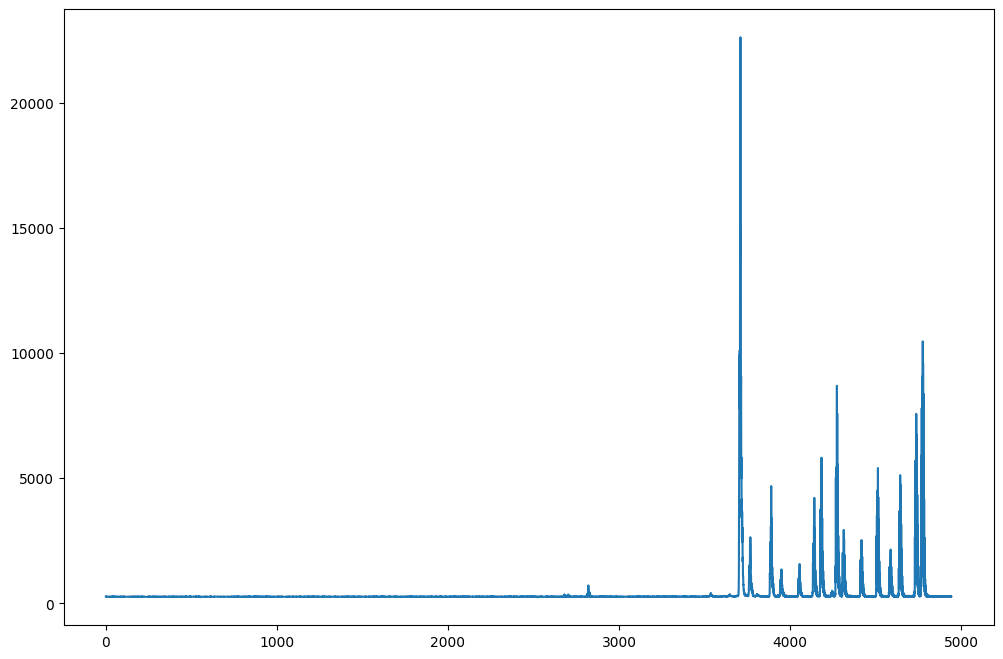

In [12]:
plt.rcParams['figure.figsize'] = FIGURE_SIZE
fig, axes = plt.subplots()
plt.plot(trace)

plt.show()

Bestimmung der Linienpositionen mit scipy.find_peaks() - es werden Linienspitzen gesucht mit einer minimalen Intensität von 0.05 und einer Distanz zur nächsten Linienspitze von 15 (Pixel)) - Die Wahl der Parameter ist so zu wählen, dass möglichst nur die Linien gefunden werden, die auch im Referenzspektrum gekennzeichnet sind.

In [13]:
peak_positions = find_peaks(trace_n,config['DEFAULT']['FIND_PEAKS']['MIN_INTENSITY'], distance=config['DEFAULT']['FIND_PEAKS']['DISTANCE'])
print(peak_positions[0])
print(peak_positions[1]['peak_heights'])

[3710 3768 3890 3950 4056 4142 4184 4274 4314 4418 4514 4588 4644 4738
 4776]
[1.         0.11697045 0.20739692 0.06016634 0.06972217 0.18651566
 0.25747655 0.38435675 0.12988852 0.11201557 0.23924969 0.09520439
 0.22668554 0.33498496 0.46292692]


Manuelle Liste der Referenzlinien zu den gefundenen Peaks - falls Nan: keine Zuordnung. Angabe in nm hier

Plot der gefundenen Linien

3710,  1.00 
3768,  0.12 
3890,  0.21 
3950,  0.06 
4056,  0.07 
4142,  0.19 
4184,  0.26 
4274,  0.38 
4314,  0.13 
4418,  0.11 
4514,  0.24 
4588,  0.10 
4644,  0.23 
4738,  0.33 
4776,  0.46 


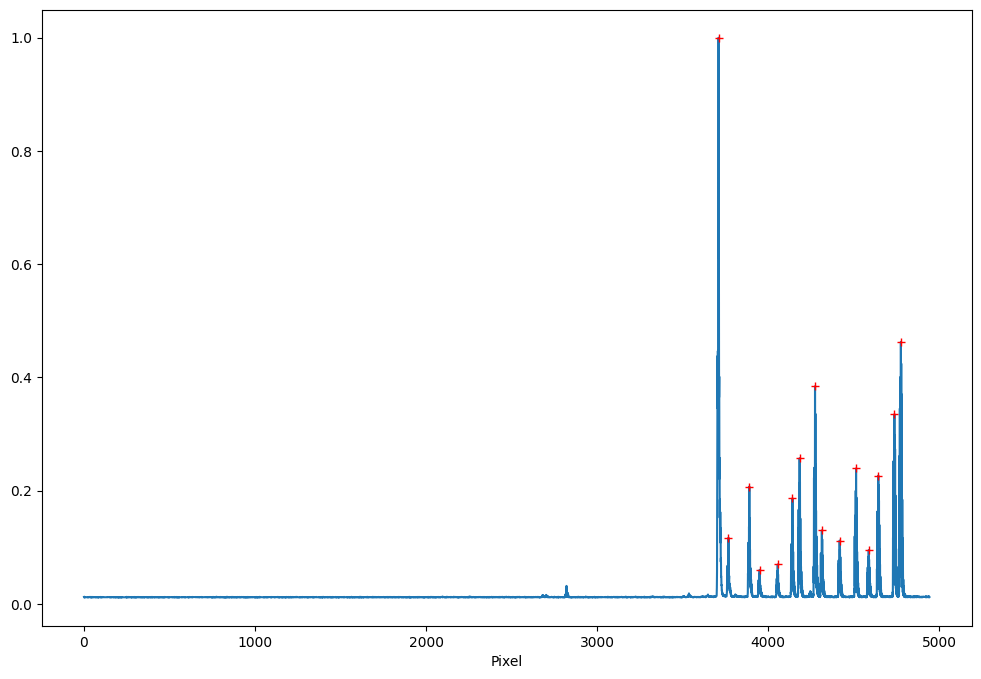

In [14]:
plt.rcParams['figure.figsize'] = FIGURE_SIZE
fig, axes = plt.subplots()
plt.plot(trace_n)
for pos,val in zip(peak_positions[0], peak_positions[1]['peak_heights']):
    print(f'{pos}, {val:5.2f} ')
    plt.plot(pos, val,'+',color='red')
plt.xlabel('Pixel')
plt.show()

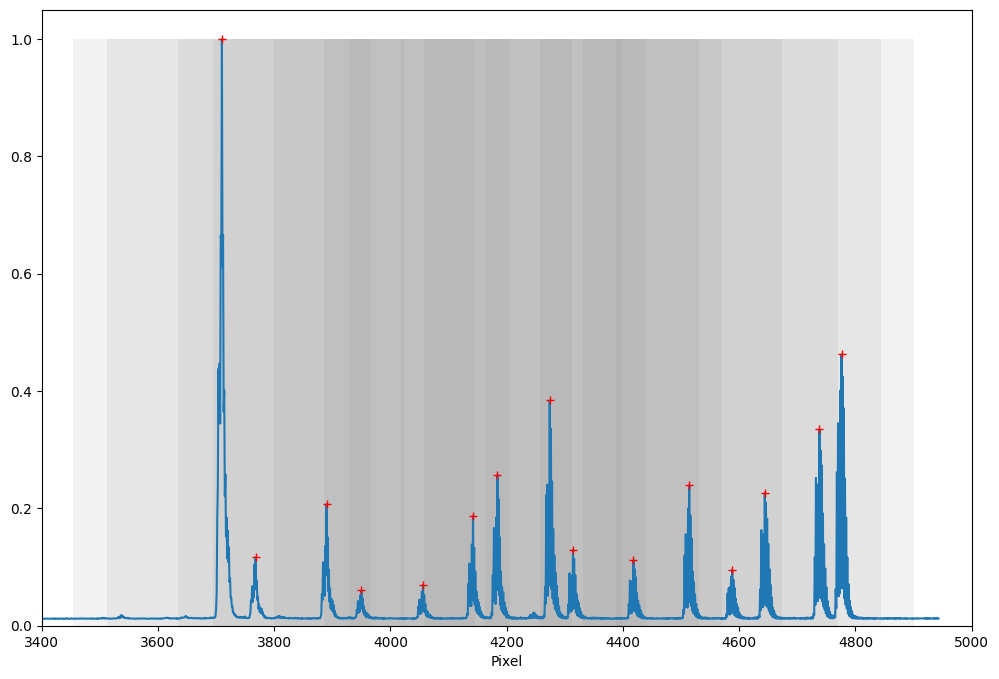

In [15]:
width = int(WINDOW/2)

box_color = [0.3,0.3,0.3,0.3]
plt.rcParams['figure.figsize'] = FIGURE_SIZE
fig, axes = plt.subplots()
axes.set_xlim(3400,5000)
plt.plot(trace_n)
for pos,val in zip(peak_positions[0], peak_positions[1]['peak_heights']):
      
    plt.plot(pos, val,'+',color='red')
    if (pos+width) < len(trace):
        plt.bar(pos,1, width=WINDOW, color='grey', alpha=0.1)
        
plt.xlabel('Pixel')
plt.show()

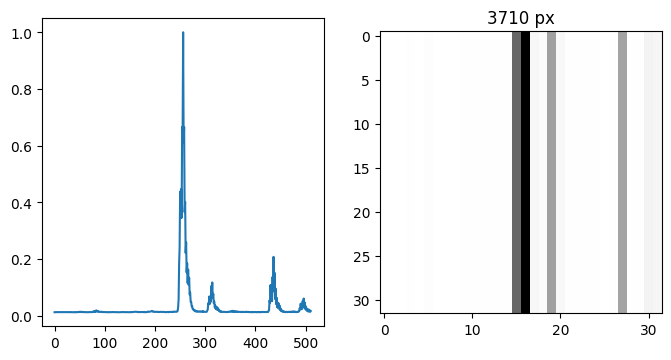

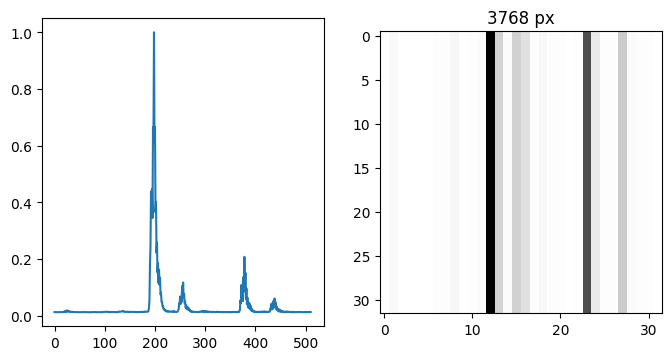

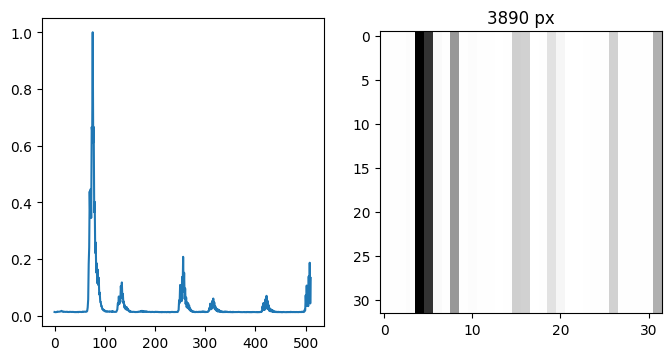

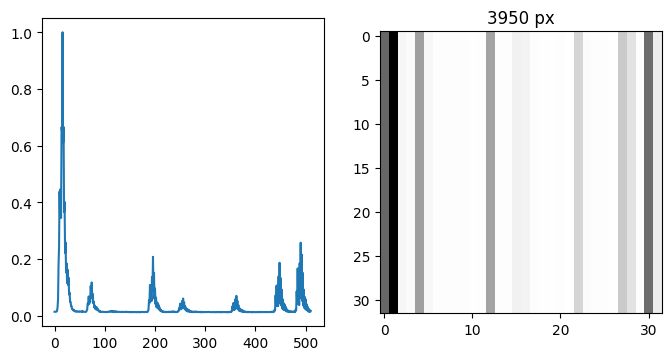

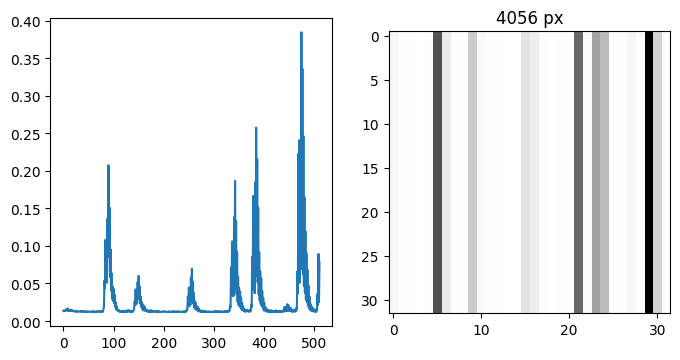

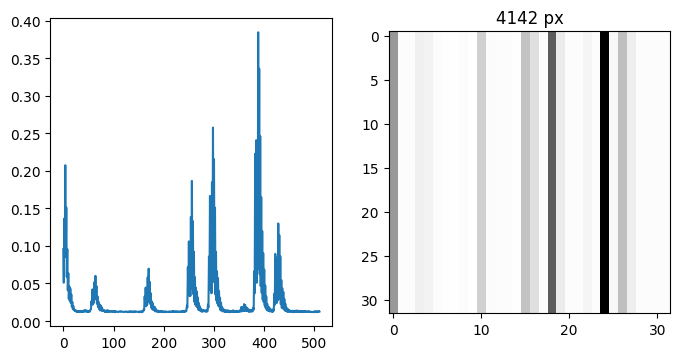

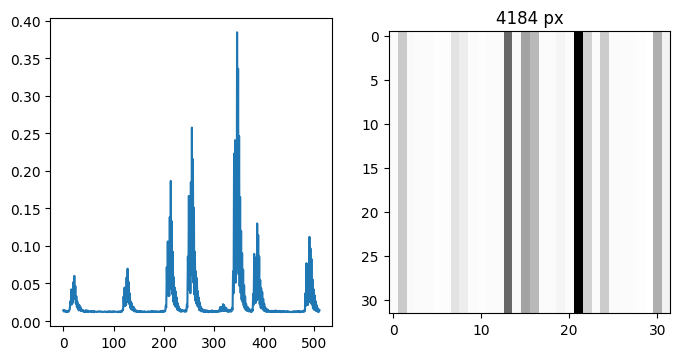

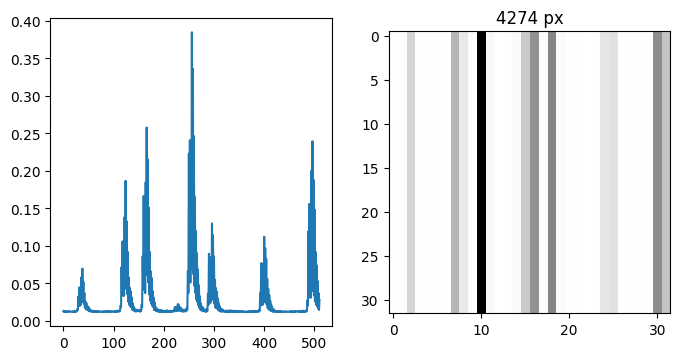

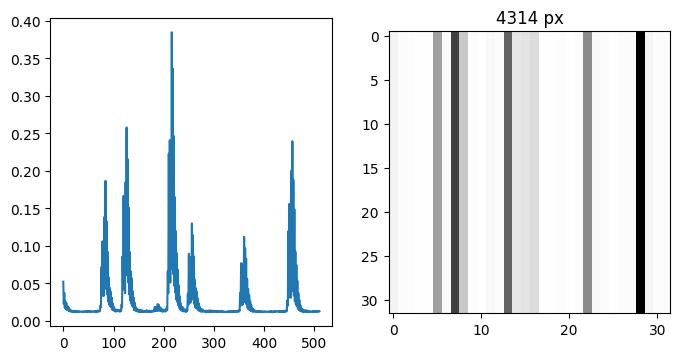

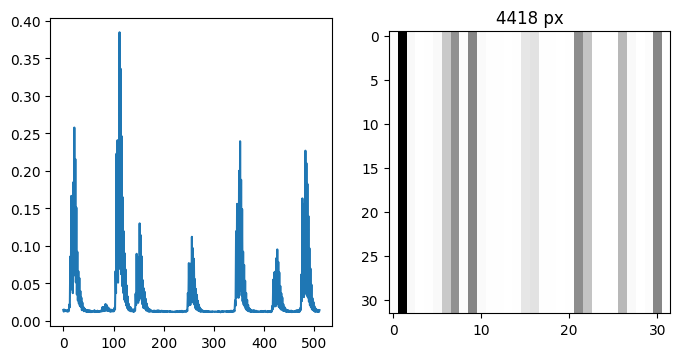

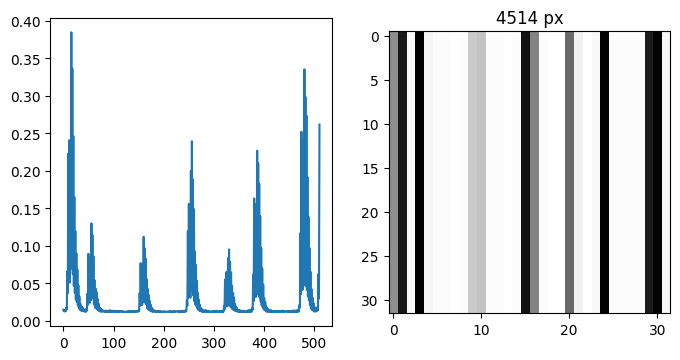

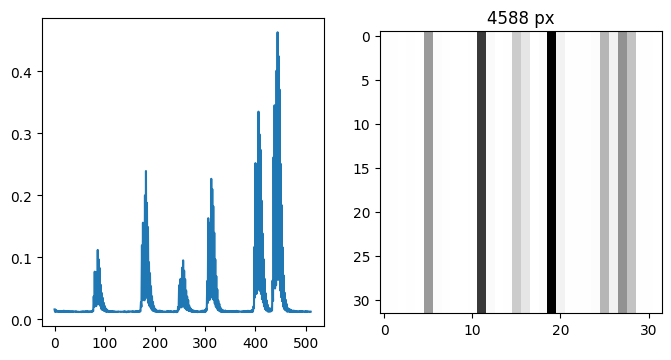

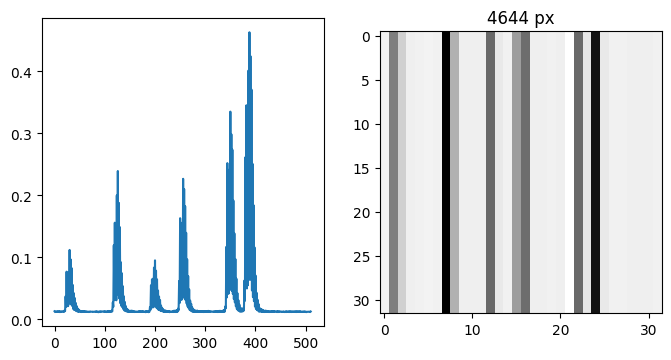

In [16]:
# 900 l/mm Gitter
#width = int(WINDOW)
#nx, ny = WINDOW*2, WINDOW*2

# 200 l/mm Gitter:
width = int(WINDOW/2)
nx, ny = WINDOW, WINDOW

for pos,val in zip(peak_positions[0], peak_positions[1]['peak_heights']):
    #print(f'{pos}, {val:5.2f} ')
    if (pos+width) < len(trace):
        plt.rcParams['figure.figsize'] = (FIGURE_SIZE[1], FIGURE_SIZE[1]/2)
        fig, axes = plt.subplots(1,2)
        plt.title(f'{pos} px')
        
        axes[0].plot(trace_n[pos-width:pos+width-1])
        
        twod = np.zeros((ny, nx))
    
        for i in range(ny):
            twod[i] = trace_n[pos-width:pos+width]*-1+1.0
        

        res = cv2.resize(np.uint8(twod * config['DEFAULT']['INTENSITY_SCALE']), dsize=(config['DEFAULT']['IMAGE_SIZE'], config['DEFAULT']['IMAGE_SIZE']), interpolation=cv2.INTER_CUBIC)
        
        axes[1].imshow(res, cmap='gray')     
        plt.show()

        img = Image.fromarray(res)
        p = TEST_DATA_PATH / f'{pos}.BMP'
        img.save(str(p), format='BMP')
    

2025-06-17 11:45:23.557267: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-06-17 11:45:23.557292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-17 11:45:23.557301: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-17 11:45:23.557314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-17 11:45:23.557323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-17 11:45:23.748493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3710
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
index_max_predictions: 0 3710 5852.48
3768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
index_max_predictions: 1 3768 5881.89
3890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 2 3890 5944.83
3950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 17 3950 6532.88
4056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
index_max_predictions: 4 4056 6029.99
4142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 5 4142 6074.33
4184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 6 4184 6096.16
4274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 8 4274 6143.06
4314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
index_max_predictions: 9 4314 6163.59
4418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 10 4418 6217.28
4514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 10 4514 6217.28
4588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
index_max_predictions: 13 4588 6334.42
4644
1/1 ━━━━━━━━━━━━━━━

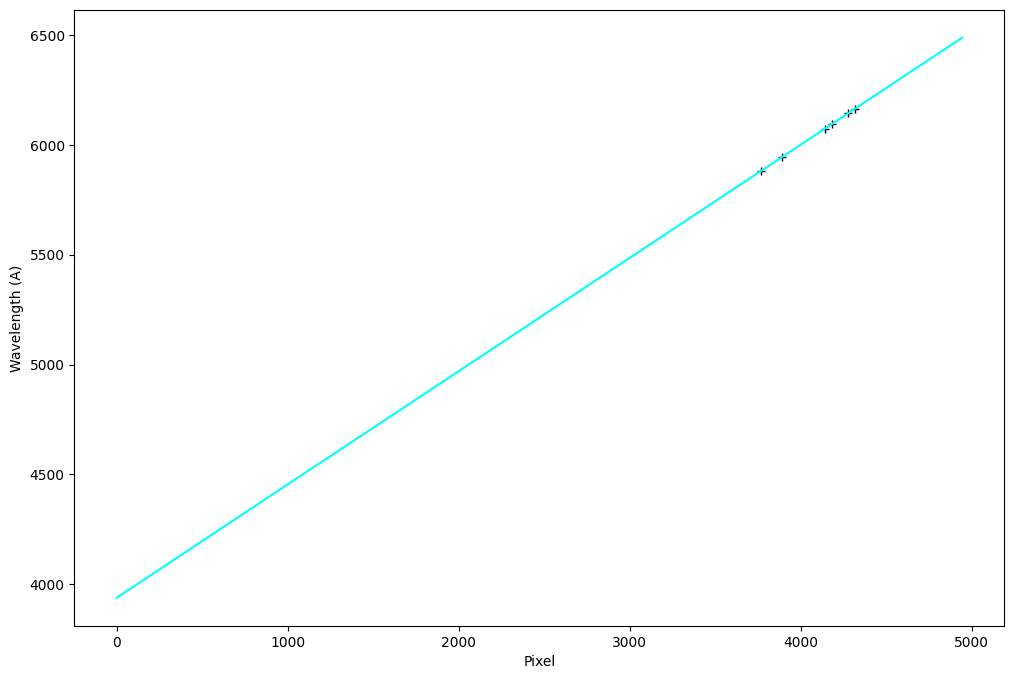

[5.15783347e-01 3.93833860e+03]


In [17]:
labels_decoded = []
for directory in sorted(os.listdir(str(config['MODEL']['TRAIN_DATA_PATH']))):
    if(directory.startswith('.') == False):
        labels_decoded.append(directory)

model = load_model(str(config['MODEL']['MODEL_FILE']))
z_ml = compute_dispersion_ml(model, labels_decoded, str(TEST_DATA_PATH), shape=data.shape)
print (z_ml)